# Film Plot Synopses as Predictors of Critical Reception

In [3]:
import pandas as pd
import numpy as np
import os
import nltk
from nltk import FreqDist, word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import enchant
english_d = enchant.Dict("en_US")
import re
import gensim
from gensim import corpora, models, similarities
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from xgboost import XGBClassifier

In [4]:
imdb = pd.read_csv('imdb_5000_movies.csv') # Just a Kaggle dataset.

The best part of this kaggle dataset is that it provides 5k+ IMdB movie ID's, which we parse and pass to the Open Movie Database API for an even richer data set. Keys to this API cost a whole dollar. Here we parse out those IMdB ID's.

In [5]:
imdb_ids = [imdb.iloc[i]['movie_imdb_link'].split('title/')[1].split('/?')[0] for i in range(len(imdb))]

### Insert code into omdb api and turn each one into its own text file

This is where we persist our API queries to files, so that we don't run into query limits and get locked out of our dataset. Our API key has been removed from this notebook.

In [6]:
# for id in imdb_ids:

#     request = requests.get(f'http://www.omdbapi.com/?i={id}&plot=full&apikey={API_KEY}').json()
#     text = str(request)  
    
#     f = open(f'movie_{id}', 'w+')
#     f.write(text)
#     f.close()

### Create new dataframe with relevant columns

Now that we've saved a bunch of files containing data about movies, we'll read them back into pandas in a tidy way:

In [7]:
#create empty dataframe with relevant columns

df = pd.DataFrame(columns=['Title', 'Year', 'ID', 'Plot', 'Genre', 'Production', 
                           'Director', 'Actor_1_name', 'Actor_1_fb_likes', 'Actor_2_name', 
                           'Actor_2_fb_likes', 'Actor_3_name', 'Actor_3_fb_likes', 'Budget', 
                           'Rated', 'Language', 'imdbRating'])

### Drawing from both the kaggle dataset and the OMdB API Data

In [8]:
for i in range(len(imdb_ids)):
    id = imdb.iloc[i]['movie_imdb_link'].split('title/')[1].split('/?')[0]
    x_file = open(os.path.join('Movies', f"movie_{id}"), "r")    #open up the movie's text file
    movie_text = x_file.readlines()[0]
    dict = eval(movie_text)    #turn string back to dictionary
    dict['Plot'] = dict['Plot'].replace("\'", "'")    #clean up
    df = df.append({'Title': dict['Title'], 'Year': dict['Year'], 'ID': id, 
                    'Plot': dict['Plot'], 'Genre': dict['Genre'], 
                    'imdbRating': dict['imdbRating'], 
                    'Director': imdb.iloc[i,:].loc['director_name'], 
                    'Actor_1_name':imdb.iloc[i,:].loc['actor_1_name'], 
                    'Actor_1_fb_likes':imdb.iloc[i,:].loc['actor_1_facebook_likes'], 
                    'Actor_2_name':imdb.iloc[i,:].loc['actor_2_name'], 
                    'Actor_2_fb_likes':imdb.iloc[i,:].loc['actor_2_facebook_likes'], 
                    'Actor_3_name':imdb.iloc[i,:].loc['actor_3_name'], 
                    'Actor_3_fb_likes':imdb.iloc[i,:].loc['actor_3_facebook_likes'], 
                    'Budget':imdb.iloc[i,:].loc['budget'], 'Language':dict['Language'], 
                    'Rated':dict['Rated']}, ignore_index=True)    #add to dataframe

### Parsing out Genres as one-hot Columns:

In [9]:
li = []
for i in range(len(df)):
    movie_genres = df.iloc[i]['Genre'].split(', ')
    li.append(movie_genres)
    
final_genres = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci_Fi', 'Sport', 'Thriller', 'War', 'Western']    

for genre in final_genres:
    list = []
    for movie in li:
        if genre in movie:
            list.append(1)
        else:
            list.append(0)
    df[genre] = list

### Remove movies with null plots and ratings, convert ratings into binary

In [10]:
df = df[~((df['Plot'] == 'N/A')|(df['imdbRating'] == 'N/A'))] # Drops movies with null plots
df.imdbRating = df.imdbRating.astype(float)
df['binary_target'] = df['imdbRating'] >= df['imdbRating'].mean()   #binary target column. True = above mean ; False = below mean
df['binary_target'] = df['binary_target'].astype(int)
df['Actor_1_fb_likes'].fillna((df['Actor_1_fb_likes'].mean()), inplace=True)
df['Actor_2_fb_likes'].fillna((df['Actor_2_fb_likes'].mean()), inplace=True)
df['Actor_3_fb_likes'].fillna((df['Actor_3_fb_likes'].mean()), inplace=True)


In [11]:
df = df.reset_index()

In [12]:
df = df.drop(['index'], axis=1)

In [13]:
df[:3]

,Title,Year,ID,Plot,Genre,Production,Director,Actor_1_name,Actor_1_fb_likes,Actor_2_name,...,Horror,Musical,Mystery,Romance,Sci_Fi,Sport,Thriller,War,Western,binary_target
0,Avatar,2009,tt0499549,"When his brother is killed in a robbery, parap...","Action, Adventure, Fantasy, Sci-Fi",NaN,James Cameron,CCH Pounder,1000.0,Joel David Moore,...,0,0,0,0,0,0,0,0,0,1
1,Pirates of the Caribbean: At World's End,2007,tt0449088,"After Elizabeth, Will, and Captain Barbossa re...","Action, Adventure, Fantasy",NaN,Gore Verbinski,Johnny Depp,40000.0,Orlando Bloom,...,0,0,0,0,0,0,0,0,0,1
2,Spectre,2015,tt2379713,A cryptic message from the past sends James Bo...,"Action, Adventure, Thriller",NaN,Sam Mendes,Christoph Waltz,11000.0,Rory Kinnear,...,0,0,0,0,0,0,1,0,0,1


### Creating a fresh DataFrame with Just the Features we Want

In [14]:
main_df = pd.DataFrame()

In [15]:
genres = df.iloc[:,-21:]
main_df['Year'] = [int(year.split('–')[0]) for year in df['Year'].values]
main_df = main_df.join(genres)

In [16]:
main_df[:3]

,Year,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,...,Horror,Musical,Mystery,Romance,Sci_Fi,Sport,Thriller,War,Western,binary_target
0,2009,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2007,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2015,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [17]:
df.plot.scatter(x='Actor_1_fb_likes',
                    y='imdbRating') # Just spotting some outliers...this prompted us to log transform fb_likes

### Log Transforming Actor Facebook Likes for use as a Feature

In [18]:
def log_transform_col(feature, dataframe):
    logged = pd.Series(np.log(dataframe[feature].values+1), name=feature+'_logged')
    return logged

actor_features = ['Actor_1_fb_likes', 'Actor_2_fb_likes','Actor_3_fb_likes']

actor_likes = [log_transform_col(actor_features[i], df) for i in range(len(actor_features))]

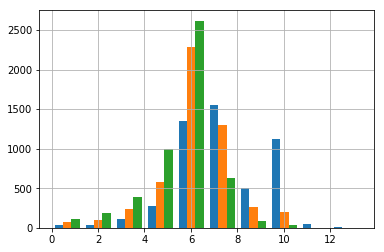

In [19]:
pd.Series(actor_likes).hist()

In [20]:
main_df = main_df.join(actor_likes)

In [21]:
main_df[:3]

,Year,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,...,Romance,Sci_Fi,Sport,Thriller,War,Western,binary_target,Actor_1_fb_likes_logged,Actor_2_fb_likes_logged,Actor_3_fb_likes_logged
0,2009,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,6.908755,6.842683,6.752270
1,2007,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,10.596660,8.517393,6.908755
2,2015,1,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,9.305741,5.976351,5.087596


### Incorporating Natural Language Processing with Plot Synopses

#### Setting up Lemmatization / Normalization Functions

In [22]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


def lemmatize(plot_list):
    lemmatized_plots = []
    for plot in plot_list:
        tokenized_lower = word_tokenize(plot.lower())   #make plot summary all lowercase and lemmatize
        
        tokenized_lower =[word for word in tokenized_lower if english_d.check(word)] # Make sure it's an english word
        
        lemmatizer = WordNetLemmatizer()
        
        dirty_lemma = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in tokenized_lower]    #lemmatize each word based on part of speech
        dirty_lemma_string = ' '.join(dirty_lemma)
        
        #filter for words that match regex pattern
        reg = re.compile((r"([a-zA-Z]+(?:'[a-z]+)?)"))    #define regular expression pattern
        lemmatized_regex = [word_lem for word_lem in dirty_lemma if word_lem in reg.findall(dirty_lemma_string)]
        
        #filter out stop words
        stop_words = set(stopwords.words('english'))
        lemmatized = [word_lem for word_lem in lemmatized_regex if not word_lem in stop_words]
        lemmatized_string = ' '.join(lemmatized)
        
        lemmatized_plots.append(lemmatized_string)
        
        
    return lemmatized_plots

In [23]:
all_plots = [plot for plot in df.loc[:,'Plot'].values] # Get all the plots.

### Running the Lemmatizer

In [24]:
plots = lemmatize(all_plots) # Lemmatize.

### Vectorizing Plots

In [25]:
#term frequency = number of times a word appears in a document / number of words in document
#inverse document frequency = log base e(number of ducuments / number of documents with word in it)
# tf:idf = tf * idf

tfidf = TfidfVectorizer()
response = tfidf.fit_transform(plots)
print(response.shape)

tfidf_df = pd.DataFrame(response.toarray(), columns=tfidf.get_feature_names())

(5037, 13807)


Now we have all plots lemmatized as "plots" and vectorized / weighted as "tfidf_df".

### Incorporating some LDA - Clustering Documents by Topic

We tried running a topic modeling algorithm over our corpus of text. "Gensim" clusters words that appear together frequently across several documents. The clusters can be interpreted as general themes, and each movie has weights of how much it belongs to each theme. These weights are then re-incorporated as features in our dataset.

In [26]:
all_words = [plot.split(' ') for plot in plots] # Just formatting our corpus how Gensim wants it

In [27]:
dictionary = corpora.Dictionary(all_words)
corpus = [dictionary.doc2bow(text) for text in all_words]
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

In [28]:
NUM_TOPICS = 30 # This value was arbitrarily chosen.
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=10) # Also arb
ldamodel.save('model5.gensim')

In [29]:
topics = ldamodel.print_topics(num_words=4)
topics # These are examples of some of the clusters created by Gensim.

[(12, '0.018*"vampire" + 0.018*"captain" + 0.015*"ship" + 0.013*"one"'),
 (23, '0.016*"cat" + 0.012*"two" + 0.010*"trip" + 0.010*"one"'),
 (29, '0.012*"game" + 0.010*"jimmy" + 0.010*"world" + 0.009*"play"'),
 (5, '0.023*"gold" + 0.009*"pearl" + 0.009*"experiment" + 0.009*"mine"'),
 (9, '0.020*"film" + 0.016*"movie" + 0.011*"cover" + 0.009*"board"'),
 (27, '0.016*"hotel" + 0.011*"mike" + 0.009*"film" + 0.008*"frank"'),
 (24, '0.009*"reach" + 0.009*"surf" + 0.008*"asylum" + 0.007*"three"'),
 (16, '0.016*"prince" + 0.013*"political" + 0.009*"boat" + 0.009*"apartment"'),
 (22, '0.014*"jack" + 0.013*"father" + 0.012*"find" + 0.011*"family"'),
 (1, '0.026*"life" + 0.010*"one" + 0.009*"year" + 0.007*"mother"'),
 (7, '0.017*"life" + 0.013*"one" + 0.010*"girl" + 0.009*"town"'),
 (19, '0.027*"school" + 0.013*"high" + 0.012*"student" + 0.012*"get"'),
 (26, '0.017*"life" + 0.016*"story" + 0.015*"love" + 0.012*"family"'),
 (15, '0.013*"find" + 0.013*"get" + 0.011*"work" + 0.011*"island"'),
 (20, '0

In [30]:
tm = pd.DataFrame()
for i in range(len(corpus)):
    new_row = np.zeros(30)
    for toop in ldamodel.get_document_topics(corpus[i]): # These two lines are where you do what you need to do
        new_row[toop[0]] = toop[1]                       # to flip zeroes to ones if the genre appears
    tm = tm.append(pd.Series(new_row), ignore_index=1)

In [31]:
tm.head() # This is a DataFrame with the weights from the GenSim clustering.

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.035075,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.054162,0.0,0.000000,0.077708,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.000000,0.0,0.044985,0.049799,0.0,0.000000,...,0.0,0.0,0.125043,0.0,0.039917,0.0,0.0,0.00000,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.175320,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.059073,0.0,0.0,0.00000,0.0,0.0
4,0.0,0.133542,0.0,0.0,0.000000,0.0,0.000000,0.074666,0.0,0.000000,...,0.0,0.0,0.105645,0.0,0.000000,0.0,0.0,0.05008,0.0,0.0


### Joining GenSim Results with Vectorized Plot Synopses

In [32]:
plots_and_topics = tfidf_df.join(tm)

In [33]:
plots_and_topics.head()

,aardvark,aback,abandon,abandonment,abate,abatement,abbey,abdicate,abduct,abduction,...,20,21,22,23,24,25,26,27,28,29
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.125043,0.0,0.039917,0.0,0.0,0.00000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.059073,0.0,0.0,0.00000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.105645,0.0,0.000000,0.0,0.0,0.05008,0.0,0.0


# EDA with Non-PlotText Features

In [34]:
import statsmodels.api as sm
import statsmodels.formula.api as sm
from patsy import dmatrices

In [35]:
# check LogReg with all initial variables from main_df (note: no plot)
s = ("binary_target ~ Year + C(Action) + C(Adventure) + C(Animation) + C(Biography) + C(Comedy)"
                 "+ C(Crime) + C(Documentary) + C(Drama) + C(Family) + C(Fantasy) + C(History)"
                 "+ C(Horror) + C(Musical) + C(Mystery) + C(Romance) + C(Sci_Fi) + C(Sport)"
                 "+ C(Thriller) + C(War)+ C(Western)"
                 "+ Actor_1_fb_likes_logged + Actor_2_fb_likes_logged"
                 "+ Actor_3_fb_likes_logged")

y, X = dmatrices(s, main_df, return_type="dataframe")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =  0.2, random_state=16)

logit_model = sm.Logit(y_train.iloc[:,0], X_train)
result = logit_model.fit()

print(result.summary())

y_preds = result.predict(X_test)

accuracy_score(y_test, y_preds >=.5)

Optimization terminated successfully.
         Current function value: 0.588562
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:          binary_target   No. Observations:                 4029
Model:                          Logit   Df Residuals:                     4005
Method:                           MLE   Df Model:                           23
Date:                Tue, 08 Jan 2019   Pseudo R-squ.:                  0.1485
Time:                        22:38:03   Log-Likelihood:                -2371.3
converged:                       True   LL-Null:                       -2784.7
                                        LLR p-value:                7.246e-160
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  85.6656      6.990     12.255      0.000      71.965   

0.6865079365079365

In [36]:
# Rerun LogReg by dropping the features with high p_values in the prior model (see above)

s = ("binary_target ~ Year + C(Action) + C(Animation) + C(Biography) + C(Comedy)"
                 "+ C(Documentary) + C(Drama) + C(Family)"
                 "+ C(Horror) + C(Mystery) + C(Romance)"
                 "+ C(Thriller)"
                 "+ Actor_1_fb_likes_logged + Actor_2_fb_likes_logged"
                 "+ Actor_3_fb_likes_logged")

main_df = main_df.drop(['Adventure','Crime', 'Fantasy', 'History', 'Musical', 'Sport', 'Sci_Fi', 'War', 'Western'], axis=1)

y, X = dmatrices(s, main_df, return_type = "dataframe")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =  0.2, random_state=16)

logit_model = sm.Logit(y_train.iloc[:,0], X_train)
result = logit_model.fit()

print(result.summary())

y_preds = result.predict(X_test)

accuracy_score(y_test, y_preds >=.5)

Optimization terminated successfully.
         Current function value: 0.588716
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:          binary_target   No. Observations:                 4029
Model:                          Logit   Df Residuals:                     4013
Method:                           MLE   Df Model:                           15
Date:                Tue, 08 Jan 2019   Pseudo R-squ.:                  0.1482
Time:                        22:38:03   Log-Likelihood:                -2371.9
converged:                       True   LL-Null:                       -2784.7
                                        LLR p-value:                2.871e-166
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  85.2044      6.931     12.293      0.000      71.620   

0.6884920634920635

In [37]:
main_df.columns

Index(['Year', 'Action', 'Animation', 'Biography', 'Comedy', 'Documentary',
       'Drama', 'Family', 'Horror', 'Mystery', 'Romance', 'Thriller',
       'binary_target', 'Actor_1_fb_likes_logged', 'Actor_2_fb_likes_logged',
       'Actor_3_fb_likes_logged'],
      dtype='object')

### Dimensionality Reduction with SVD - For the PlotText Data

In [38]:
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn import metrics

svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
plots_and_topics_pca = svd.fit_transform(plots_and_topics)

print(svd.explained_variance_ratio_.sum())

0.3204620207709506


### Naive Bayes with Combined

#### Join PlotText df and Main df:

In [39]:
df = main_df.join(pd.DataFrame(plots_and_topics_pca))
df.head()

,Year,Action,Animation,Biography,Comedy,Documentary,Drama,Family,Horror,Mystery,...,90,91,92,93,94,95,96,97,98,99
0,2009,1,0,0,0,0,0,0,0,0,...,0.014409,0.010340,0.023049,0.009313,-0.001238,-0.014220,-0.004487,0.004059,-0.028426,0.019041
1,2007,1,0,0,0,0,0,0,0,0,...,-0.017428,-0.039311,0.053905,-0.025602,0.001444,-0.045098,-0.062956,0.001939,-0.001839,0.021647
2,2015,1,0,0,0,0,0,0,0,0,...,0.020889,0.085899,-0.043359,-0.012582,0.024548,0.074223,0.016576,0.030519,-0.025810,0.025419
3,2012,1,0,0,0,0,0,0,0,0,...,-0.009887,0.008372,0.002570,0.009895,-0.026527,0.015180,-0.022938,0.028097,-0.026667,0.042914
4,2012,1,0,0,0,0,0,0,0,0,...,0.000225,0.017686,0.017861,0.020443,0.027517,0.019922,0.027536,-0.021806,0.004355,-0.023903


In [40]:
X = df.drop(['binary_target'], axis=1)
y = df['binary_target']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

In [41]:
clf = GaussianNB()
clf.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [42]:
y_preds = clf.predict(X_test)
print(metrics.classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.59      0.78      0.67       469
           1       0.74      0.53      0.61       539

   micro avg       0.64      0.64      0.64      1008
   macro avg       0.66      0.65      0.64      1008
weighted avg       0.67      0.64      0.64      1008



### PCA with Combined

In [43]:
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD


svd = TruncatedSVD(n_components=84, n_iter=50, random_state=42)
X_train_pca = svd.fit_transform(X_train)

print(svd.explained_variance_ratio_.sum())

0.9997884681653019


In [44]:
grid_clf.get_params().keys()

NameError: name 'grid_clf' is not defined

In [ ]:
from sklearn.pipeline import Pipeline


pipe = Pipeline([
    ('reduce_dim', TruncatedSVD()),
    ('classify', GradientBoostingClassifier())  
])
score = {'f1': 'f1', 'accuracy': 'accuracy'}
N_FEATURES_OPTIONS = [10, 7, 13, 15, 14]
itera = [3, 5, 7]
# max_dep = [3,4,5,6]
# n_est = [50,80,100, 120, 150]
# min_samp = [4,5,6,10]
param_grid = [
    {
        'reduce_dim': [TruncatedSVD()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'reduce_dim__n_iter': itera
#         'classify__n_estimators': n_est,
#         'classify__max_depth': max_dep,
#         'classify__min_samples_split':min_samp
    }]
reducer_labels = ['TruncatedSVD']

grid_adc = GridSearchCV(pipe, cv=5, n_jobs=-1, param_grid=param_grid, scoring=score, refit='accuracy')
grid_adc.fit(X_train, y_train)
grid_adc.best_params_

In [ ]:
y_preds = grid_adc.predict(X_test)
accuracy_score(y_test, y_preds)

In [ ]:
clf = xgb.XGBClassifier(n_jobs=-1)
clf.fit(X_train, y_train)

training_preds = clf.predict(X_train)
test_preds = clf.predict(X_test)

training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Test accuracy: {:.4}%".format(test_accuracy * 100))

### Correlation Matrices

In [ ]:
import seaborn as sns
sns.set(style='ticks', color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [ ]:
#Creating multi-scatter plot
main_corr= main_df.drop(['binary_target'], axis=1).iloc[:,:]
pd.plotting.scatter_matrix(main_corr, figsize=[15,15]);

In [43]:
#set correlation above 0.75 and see true/false values
abs(main_corr.corr())> 0.75

,Year,Action,Animation,Biography,Comedy,Documentary,Drama,Family,Horror,Mystery,Romance,Thriller,Actor_1_fb_likes_logged,Actor_2_fb_likes_logged,Actor_3_fb_likes_logged
Year,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Action,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
Animation,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
Biography,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
Comedy,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
Documentary,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
Drama,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
Family,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
Horror,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
Mystery,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False


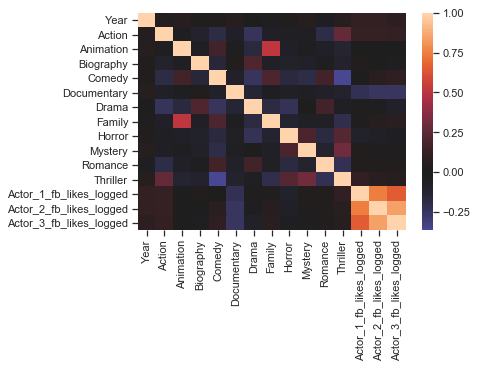

In [44]:
#we can see that the greatest collinearity is between the actor media presence
sns.heatmap(main_corr.corr(), center=0);